## Add Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

## Read In Data

In [15]:
# pokedex
df1 = pd.read_csv("data/pokedex.csv", index_col=0)
df1["image_address"] = df1["image"]
df1 = df1.drop(columns = "image")

# pokedex4
df2 = pd.read_csv("data/pokedex2.csv", index_col=0)

# concat dataframes
df = pd.concat([df1, df2])
df = df.drop(columns = "type2")
df

,dex_no,name,type1,image_name,image_address
0,1.0,Bulbasaur,Grass,pokedex_bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2.0,Ivysaur,Grass,pokedex_ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3.0,Venusaur,Grass,pokedex_venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4.0,Charmander,Fire,pokedex_charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5.0,Charmeleon,Fire,pokedex_charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...
1150,NaN,Iron_Valiant,Fairy,pokedex2_Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...
1151,NaN,Koraidon,Fighting,pokedex2_Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...
1152,NaN,Miraidon,Electric,pokedex2_Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...
1153,NaN,Walking_Wake,Water,pokedex2_Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...


In [30]:
# make new dataframe out of all the images listed in the images folder
df_imagesonly = pd.DataFrame(os.listdir("data/images"))
df_imagesonly.columns = ["image_name"]
df_imagesonly["name"] = df_imagesonly["image_name"]
df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")
df_imagesonly["name"] = df_imagesonly["name"].str.capitalize()
df_imagesonly["name"] = df_imagesonly["name"].str.split("_").apply(lambda x: x[1])
df_imagesonly["name"] = df_imagesonly["name"].str.title()

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/2797638038.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/2797638038.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")


In [32]:
# create new dataframe for just names and types
names_and_types = df[["name", "type1"]]

# combine with df_imagesonly
images_types = df_imagesonly.merge(names_and_types)
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19664,pokedex2_Ninetales-Alola.png,Ninetales-Alola,Ice
19665,pokedex_burmy.jpg,Burmy,Bug
19666,pokedex2_Raichu-Alola.png,Raichu-Alola,Electric
19667,pokedex2_Eiscue-Noice.png,Eiscue-Noice,Ice


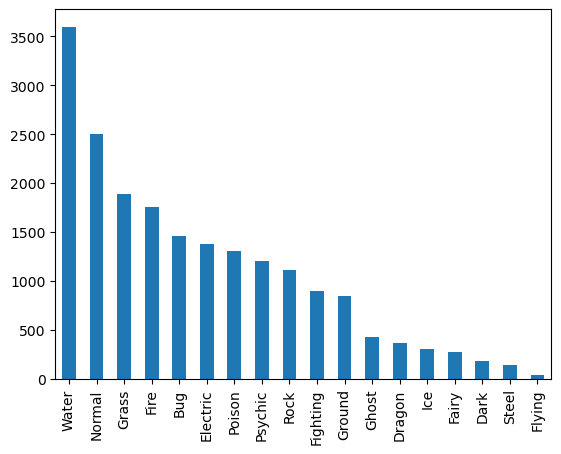

In [33]:
images_types.type1.value_counts().plot(kind='bar');

In [34]:
# remove rows that do not contain main types
main_types = ["Water", "Normal", "Grass", "Pyschic", "Bug", "Fire", "Poison", "Ground", "Fighting", "Rock"]
images_types = images_types[images_types['type1'].isin(main_types)]
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19656,pokedex2_Typhlosion-Hisui.png,Typhlosion-Hisui,Fire
19657,pokedex_urshifu.jpg,Urshifu,Fighting
19658,pokedex_shellos.jpg,Shellos,Water
19659,pokedex2_Slowbro-Galar.png,Slowbro-Galar,Poison


## Split Folders for Train-Test and By Class

In [39]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.0, 0.2)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df_tts = pd.concat(pdList)
df_tts

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/919130472.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["split"] = "train"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_3144/919130472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["split"] = "test"


,image_name,name,type1,split
4,dataset_Dodrio26.jpg,Dodrio,Normal,train
5,dataset_Dodrio26.jpg,Dodrio,Normal,train
6,dataset_Dodrio32.jpg,Dodrio,Normal,train
7,dataset_Dodrio32.jpg,Dodrio,Normal,train
8,dataset_Dodrio24.jpg,Dodrio,Normal,train
...,...,...,...,...
19645,pokedex2_Shellos-East.png,Shellos-East,Water,test
19649,pokedex2_Burmy-Sandy.png,Burmy-Sandy,Bug,test
19650,pokedex2_Lycanroc-Dusk.png,Lycanroc-Dusk,Rock,test
19651,pokedex2_Burmy-Trash.png,Burmy-Trash,Bug,test


In [48]:
df_tts = df_tts.drop_duplicates('image_name')

In [49]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'

for index, row in df_tts.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label))

In [50]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (224, 224), color_mode ='rgb', 
                                                    batch_size = 32, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size = (224, 224), color_mode ='rgb',
                                              batch_size = 32, class_mode='categorical')

Found 6129 images belonging to 9 classes.
Found 1534 images belonging to 9 classes.


## Base Model

For the base model, we're going to use a simple convolutional model set up with a kernel size of (2,2). We'll have three layers between our input and output.

In [61]:
reg = l2(3e-3)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(9, activation='softmax', kernel_regularizer = reg))

In [62]:
cce = tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

In [63]:
base_model = model.fit(
        train_generator, verbose = 1, 
        validation_data = test_generator, 
        epochs=10)

Epoch 1/10


2023-03-28 13:41:57.417856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - ETA: 0s - loss: 2.8928 - accuracy: 0.2725

2023-03-28 13:43:15.113400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 94s 488ms/step - loss: 2.8928 - accuracy: 0.2725 - val_loss: 2.2343 - val_accuracy: 0.3227
Epoch 2/10
192/192 [==============================] - 93s 486ms/step - loss: 2.1812 - accuracy: 0.3363 - val_loss: 2.2904 - val_accuracy: 0.3351
Epoch 3/10
192/192 [==============================] - 94s 488ms/step - loss: 2.0865 - accuracy: 0.3674 - val_loss: 2.0397 - val_accuracy: 0.3742
Epoch 4/10
192/192 [==============================] - 93s 486ms/step - loss: 2.0322 - accuracy: 0.3816 - val_loss: 2.0182 - val_accuracy: 0.3937
Epoch 5/10
192/192 [==============================] - 93s 487ms/step - loss: 2.0109 - accuracy: 0.3867 - val_loss: 2.0611 - val_accuracy: 0.3422
Epoch 6/10
 48/192 [======>.......................] - ETA: 57s - loss: 1.9595 - accuracy: 0.3978

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x34ebcc4a0>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 93s 487ms/step - loss: 1.9903 - accuracy: 0.3976 - val_loss: 1.9861 - val_accuracy: 0.3664
Epoch 7/10
192/192 [==============================] - 93s 485ms/step - loss: 1.9613 - accuracy: 0.3944 - val_loss: 1.9073 - val_accuracy: 0.4074
Epoch 8/10
192/192 [==============================] - 93s 485ms/step - loss: 1.9724 - accuracy: 0.4105 - val_loss: 1.9430 - val_accuracy: 0.4465
Epoch 9/10
  9/192 [>.............................] - ETA: 1:14 - loss: 1.7024 - accuracy: 0.5000

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x34ebced00>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 93s 486ms/step - loss: 1.9152 - accuracy: 0.4459 - val_loss: 1.9183 - val_accuracy: 0.4635
Epoch 10/10
192/192 [==============================] - 93s 486ms/step - loss: 1.8831 - accuracy: 0.4585 - val_loss: 1.9929 - val_accuracy: 0.4179


Not bad for a base! Nearly 50% accuracy for train and test. Let's plot it and see what these epochs look like in terms of loss and accuracy.

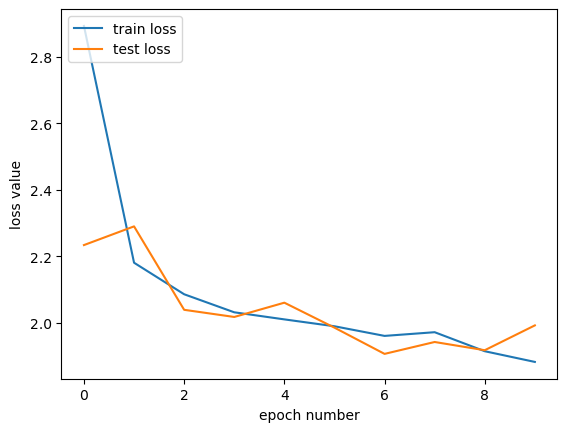

In [64]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

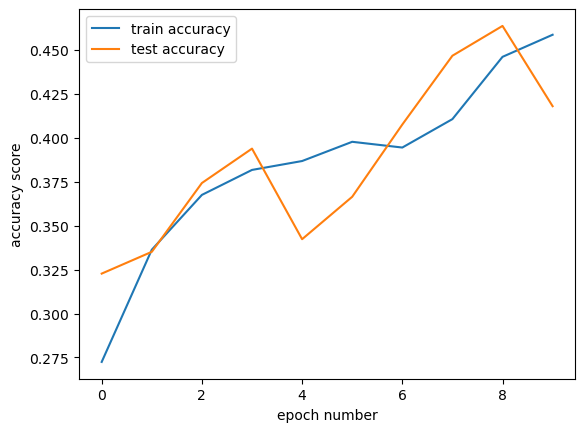

In [65]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

It'll help us to know what's getting mislabeled. Let's do a confusion matrix using the types we've inputted previously.

48/48 [==============================] - 16s 330ms/step


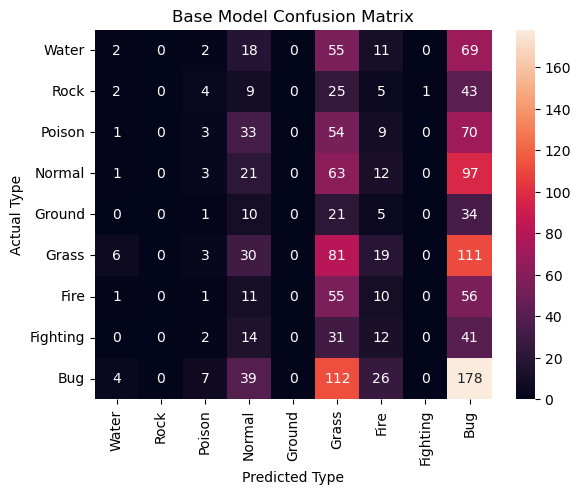

In [125]:
# new labels
types = ["Water", "Rock", "Poison", "Normal", "Ground", "Grass", "Fire", "Fighting", "Bug"]

# get predicted values
Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Base Model Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

It looks like Bug and Grass are often mistaken for each other, which makes sense. Usually these types overlap considerably with some Pokémon having both types. They're also often both green-colored.

Some Normal types are also being mistaken for Bug types. In fact, our predicted Bug types and our Grass types overall seem to be having the most issues. Normal type is also having issues. Nothing seems to be getting labeled as Ground or Fighting types, which is a problem.

## Model 2

It seemed like accuracy was going up with each epoch. For the next model, Model 2, let's increase the number of epochs and add a few more layers to help the neural network parse the differences for what it was confusing before.

In [128]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))

model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_regularizer = reg))
model2.add(Dense(64, activation='relu', kernel_regularizer = reg))
model2.add(Dense(64, activation='relu', kernel_regularizer = reg))
model2.add(Dense(32, activation='relu', kernel_regularizer = reg))
model2.add(Dense(32, activation='relu', kernel_regularizer = reg))
model2.add(Dense(16, activation='relu', kernel_regularizer = reg))
model2.add(Dense(9, activation='softmax', kernel_regularizer = reg))
model2.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_2 = model2.fit(train_generator, verbose = 1, validation_data = test_generator, epochs = 20)

Epoch 1/20


2023-03-28 14:35:52.185335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - ETA: 0s - loss: 4.4917 - accuracy: 0.2389

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x34e8e4b40>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1
2023-03-28 14:37:09.606288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 94s 488ms/step - loss: 4.4917 - accuracy: 0.2389 - val_loss: 2.3705 - val_accuracy: 0.2588
Epoch 2/20
192/192 [==============================] - 94s 487ms/step - loss: 2.3102 - accuracy: 0.2762 - val_loss: 2.2210 - val_accuracy: 0.2940
Epoch 3/20
192/192 [==============================] - 93s 485ms/step - loss: 2.2272 - accuracy: 0.2899 - val_loss: 2.1973 - val_accuracy: 0.2992
Epoch 4/20
192/192 [==============================] - 93s 487ms/step - loss: 2.2005 - accuracy: 0.2878 - val_loss: 2.1605 - val_accuracy: 0.2999
Epoch 5/20
192/192 [==============================] - 93s 485ms/step - loss: 2.1599 - accuracy: 0.2986 - val_loss: 2.1154 - val_accuracy: 0.3149
Epoch 6/20
192/192 [==============================] - 94s 488ms/step - loss: 2.1346 - accuracy: 0.3017 - val_loss: 2.1021 - val_accuracy: 0.3429
Epoch 7/20
192/192 [==============================] - 94s 490ms/step - loss: 2.1155 - accuracy: 0.3022 - val_loss: 2.0641 - val_accuracy: 0.3

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x3289edf90>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 94s 489ms/step - loss: 1.9825 - accuracy: 0.3397 - val_loss: 1.9498 - val_accuracy: 0.3468
Epoch 15/20
192/192 [==============================] - 94s 488ms/step - loss: 1.9936 - accuracy: 0.3361 - val_loss: 2.0372 - val_accuracy: 0.3070
Epoch 16/20
192/192 [==============================] - 94s 489ms/step - loss: 1.9792 - accuracy: 0.3369 - val_loss: 1.9279 - val_accuracy: 0.3722
Epoch 17/20
192/192 [==============================] - 94s 490ms/step - loss: 1.9588 - accuracy: 0.3444 - val_loss: 1.9151 - val_accuracy: 0.3592
Epoch 18/20
192/192 [==============================] - 94s 489ms/step - loss: 1.9638 - accuracy: 0.3399 - val_loss: 1.9091 - val_accuracy: 0.3703
Epoch 19/20
192/192 [==============================] - 94s 490ms/step - loss: 1.9436 - accuracy: 0.3335 - val_loss: 1.8957 - val_accuracy: 0.3625
Epoch 20/20
192/192 [==============================] - 93s 485ms/step - loss: 1.9377 - accuracy: 0.3400 - val_loss: 1.8947 - val_accurac

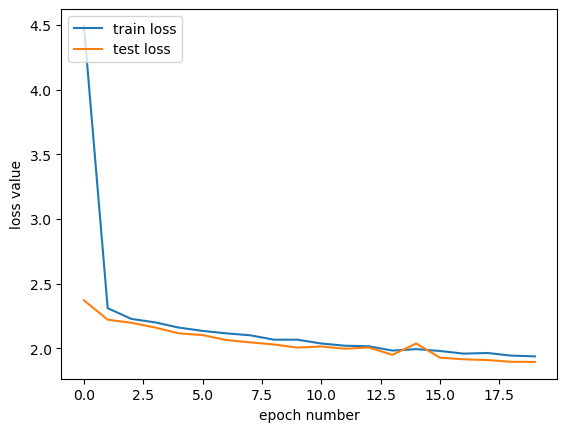

In [129]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

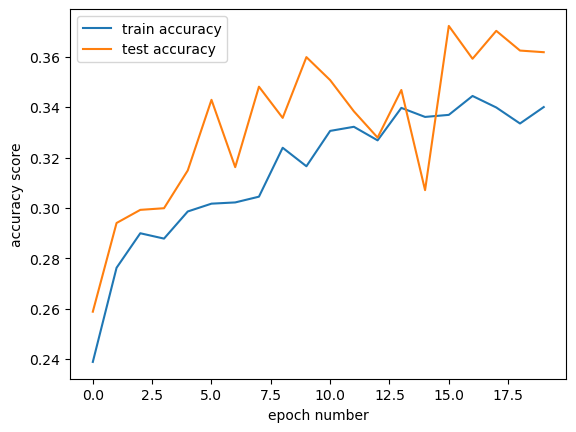

In [130]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

Accuracy doesn't seem to have improved from the base model to this one by adding the extra layers. Let's see what the model is getting wrong.

 1/48 [..............................] - ETA: 7s

2023-03-28 15:07:23.542459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 16s 329ms/step


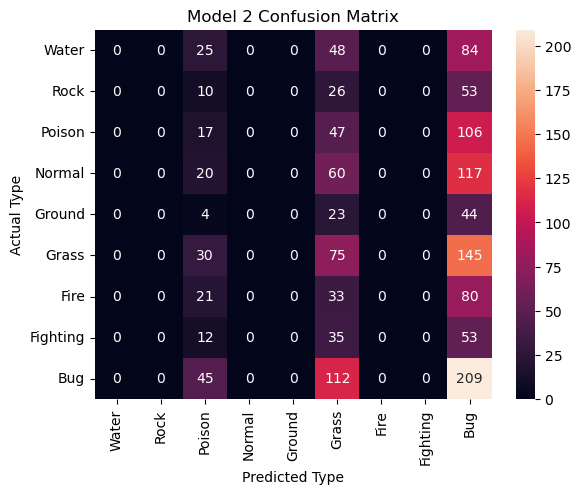

In [131]:
# get predicted values
Y_pred = model2.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 2 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

The mislabeling between Bug and Grass types seems to be worse here, as does Normal and bug types. Now even Fire, Water, Rock, and Normal are all losing labels. The accuracy overall is worse.

## Model 3

What if we went back to the first model but added more epochs and included Dropout? Model 3 will show what this does for us. 

In [133]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))

model3.add(Flatten())
model3.add(Dense(64, activation='relu', kernel_regularizer = reg))

model3.add(Dropout(0.2))

model3.add(Dense(32, activation='relu', kernel_regularizer = reg))

model3.add(Dropout(0.1))

model3.add(Dense(16, activation='relu', kernel_regularizer = reg))
model3.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model3.compile(optimizer='adam', loss=cce,  metrics=['accuracy'])
model_3 = model3.fit(train_generator, verbose=1, validation_data = test_generator, epochs=20)

Epoch 1/20


2023-03-28 15:09:00.269058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/192 [..............................] - ETA: 1:19 - loss: 11.5290 - accuracy: 0.2344

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


192/192 [==============================] - ETA: 0s - loss: 2.7746 - accuracy: 0.3200

2023-03-28 15:10:17.563583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 94s 486ms/step - loss: 2.7746 - accuracy: 0.3200 - val_loss: 2.1700 - val_accuracy: 0.4029
Epoch 2/20
192/192 [==============================] - ETA: 0s - loss: 2.1584 - accuracy: 0.3862

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x3bcc2f490>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 94s 487ms/step - loss: 2.1584 - accuracy: 0.3862 - val_loss: 2.0240 - val_accuracy: 0.4172
Epoch 3/20
 67/192 [=========>....................] - ETA: 49s - loss: 2.0636 - accuracy: 0.4179

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x37952a890>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 93s 486ms/step - loss: 2.0960 - accuracy: 0.4050 - val_loss: 2.0630 - val_accuracy: 0.4166
Epoch 4/20
192/192 [==============================] - 94s 488ms/step - loss: 2.0743 - accuracy: 0.3999 - val_loss: 1.9885 - val_accuracy: 0.4426
Epoch 5/20
192/192 [==============================] - 94s 489ms/step - loss: 2.0248 - accuracy: 0.4120 - val_loss: 2.0043 - val_accuracy: 0.4153
Epoch 6/20
 80/192 [===========>..................] - ETA: 44s - loss: 2.0110 - accuracy: 0.4024

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x3ab271ef0>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 93s 486ms/step - loss: 1.9924 - accuracy: 0.4113 - val_loss: 1.9198 - val_accuracy: 0.4374
Epoch 7/20
192/192 [==============================] - 92s 482ms/step - loss: 2.0129 - accuracy: 0.4196 - val_loss: 1.9841 - val_accuracy: 0.4296
Epoch 8/20
192/192 [==============================] - 93s 483ms/step - loss: 1.9920 - accuracy: 0.4138 - val_loss: 1.9336 - val_accuracy: 0.4426
Epoch 9/20
192/192 [==============================] - 92s 477ms/step - loss: 1.9895 - accuracy: 0.4180 - val_loss: 1.8995 - val_accuracy: 0.4394
Epoch 10/20
192/192 [==============================] - 92s 479ms/step - loss: 1.9876 - accuracy: 0.4288 - val_loss: 1.9638 - val_accuracy: 0.4413
Epoch 11/20
192/192 [==============================] - 93s 485ms/step - loss: 1.9647 - accuracy: 0.4320 - val_loss: 1.9147 - val_accuracy: 0.4563
Epoch 12/20
192/192 [==============================] - 93s 485ms/step - loss: 1.9589 - accuracy: 0.4371 - val_loss: 1.9298 - val_accuracy: 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x12a7559c0>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 93s 485ms/step - loss: 1.9424 - accuracy: 0.4738 - val_loss: 1.9698 - val_accuracy: 0.4524
Epoch 18/20
192/192 [==============================] - 93s 486ms/step - loss: 1.9482 - accuracy: 0.4802 - val_loss: 2.0072 - val_accuracy: 0.4700
Epoch 19/20
192/192 [==============================] - 93s 485ms/step - loss: 1.9225 - accuracy: 0.5030 - val_loss: 2.0829 - val_accuracy: 0.4537
Epoch 20/20
192/192 [==============================] - 93s 486ms/step - loss: 1.9103 - accuracy: 0.5296 - val_loss: 2.1135 - val_accuracy: 0.4465


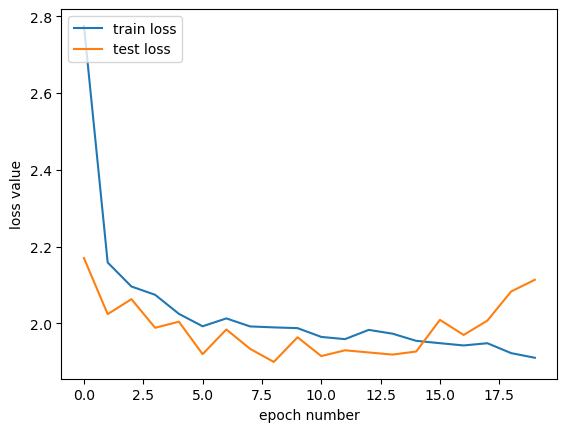

In [134]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

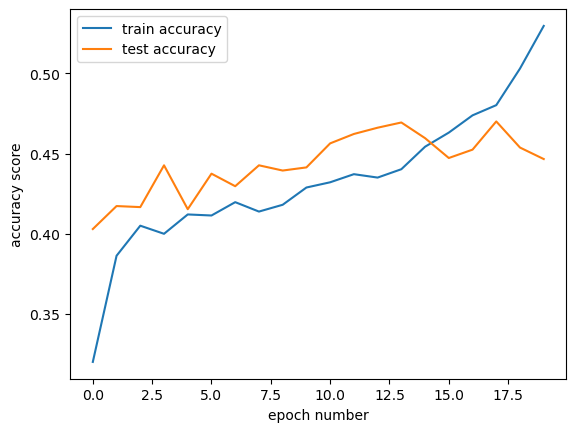

In [135]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

Train accuracy was continuing to go up with each epoch while test accuracy faltered around epoch 17. Maybe more epochs will increase accuracy overall. Dropout didn't seem to cause any problems for our model and might be worth keeping in.

 1/48 [..............................] - ETA: 4s

2023-03-28 15:40:22.478726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 16s 329ms/step


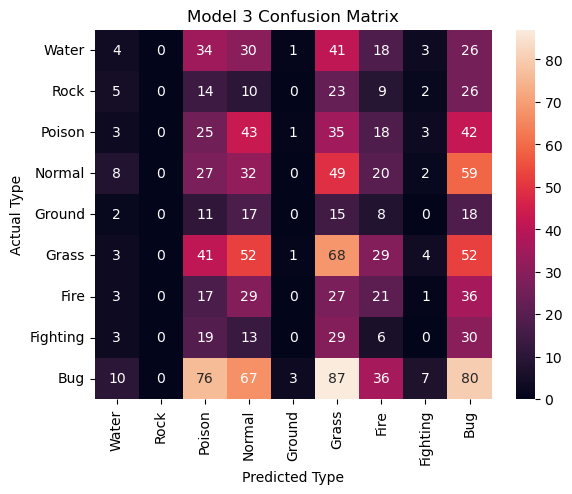

In [136]:
# get predicted values
Y_pred = model3.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 3 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

Finally, more types seem to be getting labeled. Rock is still not getting much. Dropout seems to have helped with this. We can toggle Dropout rates to be higher and see what effect that has in the next model.

## Model 4

As explained earlier, we'll increase the Dropout rate. It might also be useful to add more epochs since train accuracy seems to improve across epochs.

In [137]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(64, (3, 3), activation='relu'))

model4.add(Flatten())
model4.add(Dense(64, activation='relu', kernel_regularizer = reg))

model4.add(Dropout(0.8))

model4.add(Dense(32, activation='relu', kernel_regularizer = reg))

model4.add(Dropout(0.5))

model4.add(Dense(16, activation='relu', kernel_regularizer = reg))
model4.add(Dense(9, activation='softmax', kernel_regularizer = reg))

model4.compile(optimizer='adam', loss=cce,  metrics=['accuracy'])
model_4 = model4.fit(train_generator, verbose=1, validation_data = test_generator, epochs=20)

Epoch 1/50


2023-03-28 15:44:00.934156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 16/192 [=>............................] - ETA: 1:12 - loss: 7.8430 - accuracy: 0.1816

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


192/192 [==============================] - ETA: 0s - loss: 3.2745 - accuracy: 0.2190

2023-03-28 15:45:18.861513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 94s 489ms/step - loss: 3.2745 - accuracy: 0.2190 - val_loss: 2.3744 - val_accuracy: 0.2386
Epoch 2/50
192/192 [==============================] - 94s 489ms/step - loss: 2.2951 - accuracy: 0.2338 - val_loss: 2.2389 - val_accuracy: 0.2386
Epoch 3/50
192/192 [==============================] - 94s 490ms/step - loss: 2.2400 - accuracy: 0.2338 - val_loss: 2.2209 - val_accuracy: 0.2386
Epoch 4/50
192/192 [==============================] - 94s 488ms/step - loss: 2.2191 - accuracy: 0.2336 - val_loss: 2.1960 - val_accuracy: 0.2386
Epoch 5/50
 21/192 [==>...........................] - ETA: 1:09 - loss: 2.1209 - accuracy: 0.2738

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x2d15aef30>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 94s 488ms/step - loss: 2.1941 - accuracy: 0.2382 - val_loss: 2.1853 - val_accuracy: 0.2386
Epoch 6/50
192/192 [==============================] - 94s 489ms/step - loss: 2.1960 - accuracy: 0.2336 - val_loss: 2.1758 - val_accuracy: 0.2386
Epoch 7/50
192/192 [==============================] - 94s 488ms/step - loss: 2.1875 - accuracy: 0.2336 - val_loss: 2.1675 - val_accuracy: 0.2386
Epoch 8/50
192/192 [==============================] - 94s 487ms/step - loss: 2.1785 - accuracy: 0.2336 - val_loss: 2.1600 - val_accuracy: 0.2386
Epoch 9/50
192/192 [==============================] - 93s 483ms/step - loss: 2.1700 - accuracy: 0.2336 - val_loss: 2.1526 - val_accuracy: 0.2386
Epoch 10/50
192/192 [==============================] - 94s 488ms/step - loss: 2.1633 - accuracy: 0.2336 - val_loss: 2.1451 - val_accuracy: 0.2386
Epoch 11/50
192/192 [==============================] - 93s 487ms/step - loss: 2.1566 - accuracy: 0.2336 - val_loss: 2.1385 - val_accuracy: 0

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x2ce74eba0>
    label = <none> 
    device = <AGXG13XDevice: 0x11af99000>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10b037c00>
        label = <none> 
        device = <AGXG13XDevice: 0x11af99000>
            name = Apple M1 Pro 
    retainedReferences = 1


192/192 [==============================] - 93s 485ms/step - loss: 2.1344 - accuracy: 0.2371 - val_loss: 2.1271 - val_accuracy: 0.2386
Epoch 14/50
192/192 [==============================] - 94s 488ms/step - loss: 2.1391 - accuracy: 0.2336 - val_loss: 2.1221 - val_accuracy: 0.2386
Epoch 15/50
192/192 [==============================] - 94s 487ms/step - loss: 2.1345 - accuracy: 0.2336 - val_loss: 2.1176 - val_accuracy: 0.2386
Epoch 16/50
192/192 [==============================] - 93s 486ms/step - loss: 2.1303 - accuracy: 0.2336 - val_loss: 2.1130 - val_accuracy: 0.2386
Epoch 17/50
 99/192 [==============>...............] - ETA: 37s - loss: 2.1263 - accuracy: 0.2348

KeyboardInterrupt: 

In [ ]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

In [ ]:
# get predicted values
Y_pred = model4.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 4 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

## Model 5